# Including confounders in association studies

It is known that technical factors influence gene expression. For example, time between death and tissue harvesting is strongly associated to the expression of specific genes.

We have generated image features from the final layer of a neural network (Inceptionetv3) retrained to differentiate between tissue types. Interestingly, certain features are strongly correlated with technical variation, suggesting that this technical variation manifests in the images. The transcripts that are known to be associated with these technical factors, then have a relationship to these image features.

Are these image features associated with variation that is not purely technical? We use linear mixed models (LMMs) to answer this question. The goal is to account for known technical variation in the model, and only report unaccounted associations that are more likely to be biologically interesting.

One result of having technical factors causing so many associations is that it means that the resulting p-values are **highly inflated**. This means that we see far more significant pvalues than we expect to. For example, take the raw associations between the top 100 varying image features and the 100 most highly expressed genes along with the 100 most highly expressed transcripts. We show a QQ plot, which is a graph comparing the expected number of highly associated genes to the number of strong associations we expect to see by chance.

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


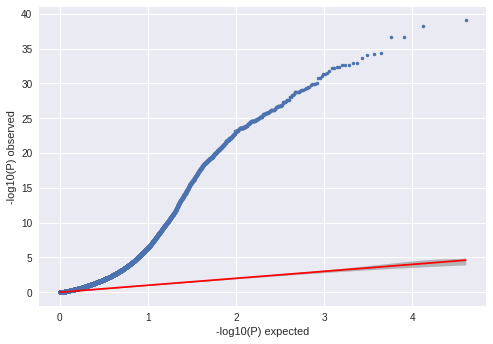

In [35]:
from limix.plot import qqplot
most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))
pvalues = results['mean_256_pvalues'].flatten()
qqplot(pvalues,alphaLevel=0.05)

We see many more strongly associated -log10 p-values than we expect.

We can quantify the level of inflation by looking at the $\lambda$ statistic. The lambda distribution looks at the distribution of the test statistic before they are converted into p-values. The $\lambda$ value is defined as the median of the test-statistics, which are $\chi^2$, divided by the median of the $\chi^2$ distribution with one degree of freedom, which is 0.454. This value is also implemented in limix as shown below.

We can also see how these pvalues stack in a histogram.

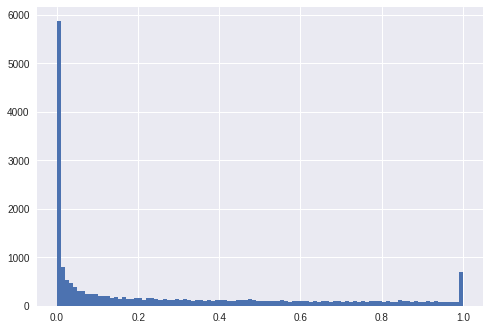

In [40]:
plt.hist(pvalues,bins=100)
plt.show()

In [49]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    L = (LOD2 / 0.456)
    return (L)

In [50]:
estimate_lambda(pvalues)

5.0589366899190527

We see an extremely high value of $\lambda$ for these p-values. Trustworthy sets of p-values are generally close to 1. We would like to correct for this and achieve fewer globally associated p-values.

## Linear mixed models

Linear mixed models account for known variation in linear models. They do this by quantifying the variation caused by **fixed effects** and **random effects** with respect to $i$ subjects.

$$ Y_i = X_i \beta + Z_iu_i + \epsilon_i $$

In our case, we have only one subject. Therefore $i = 1$

$$ Y = X \beta + Zu + \epsilon $$

$$u \sim N(0,D), \ \ \ \epsilon \sim N(0,R) $$

The $X\beta$ corresponds to the fixed effect, and the $Zu + \epsilon$ corresponds to the random effect. $Y$ here represents our dependent phenotype.

In our specific case, we want to quantify the variation of our image features outside of known technical factors. As such, we treat these factors as **fixed effects**. Fixed-effects are commonly used to capture the effect of being in a group, whereas random effect capture the effect of repeated trials from a single individual. Right now, we do not have any repeated measures, so we do not include random effects.

Our models do not include 

LMM are already included in limix - a package developed by the Stegle group at the EBI which implements well known models from statistical genetics. Specifically, it is included as `limix.qtl.qtl_test_lmm`. This function takes in as parameters the snps matrix and phenotype vector, as well as optional parameters specifying the covariance structure of the data that we want to include as fixed effects. In our data, we have a matrix of gene expression values, but this can be inputted into limix without a problem. 

## Specifying the technical covariates

To specify the technical covariates, we mine the phenotype data.

In [88]:
import pickle
import pandas as pd
import gzip
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

# import pandas as pd
# df = pickle.load(open(GTEx_directory + '/data/phenotype_pandas_dataframe.py','rb'))

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]

SMTSISCH = np.log(np.array(lung_df['SMTSISCH']).astype(np.float32))
SMTSISCH = SMTSISCH[phenotype_idx]
SMRIN = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMRIN']) ])
SMRIN = SMRIN[phenotype_idx]
SMEXNCRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMEXNCRT']) ])
SMEXNCRT = SMEXNCRT[phenotype_idx]
SMNTRNRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMNTRNRT']) ])
SMNTRNRT = SMNTRNRT[phenotype_idx]

These acronyms, SMTSISCH, SMRIN, SMEXNCRT, and SMNTRNRT mean:
- Time between tissue death and harvesting
- RIN number (RNA degradation)
- Exon mapping number
- Intro mapping number

Respectively. They can directly be added into lmm as covariates.

Now we load in all the precomputed features

In [3]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn
import pickle
import pandas

import h5py
mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = expression[:,most_varying_feature_idx]

We take the top 100 most variable image features, along with the top 100 transcripts with highest mean expression and the 100 transcript with the highest variance

In [16]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)


In [18]:
from limix.qtl import qtl_test_lmm
feature = 0
single_feature = filt_features[:,feature].copy()
qtl_test_lmm(single_feature, filt_expression.astype(float))

ValueError: array must be of type int, float, long or double